✅ Feature-engineered Excels saved: train_features.xlsx, test_features.xlsx
✅ Predictions saved → predictions_selected_features.xlsx


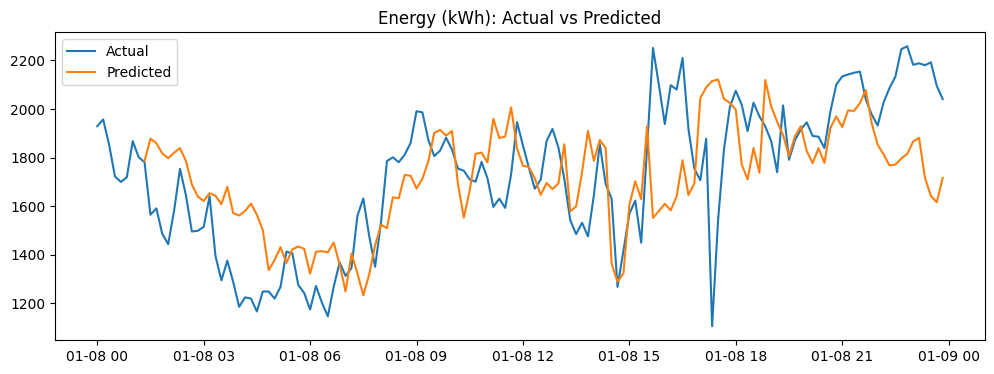

In [ ]:

import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ---------------------------
# Read Excel and clean numeric columns
# ---------------------------
def read_excel(path):
    df = pd.read_excel(path, engine="openpyxl")
    for col in df.columns:
        if col == "Date":
            continue
        if col == "Energy (kWh)":
            # Remove commas used as thousands separators (e.g. "1,015" → "1015")
            df[col] = df[col].astype(str).str.replace(",", "", regex=False).replace("-", np.nan)
            df[col] = pd.to_numeric(df[col], errors="coerce")
        else:
            # Normal cleaning for other numeric columns
            df[col] = (
                df[col].astype(str)
                .str.replace(",", ".", regex=False)   # decimal comma → dot
                .replace("-", np.nan)
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    return df



# ---------------------------
# Feature engineering (selected features)
# ---------------------------
def make_selected_features(df):
    df = df.copy()
    step = (df["Date"].dt.hour * 60 + df["Date"].dt.minute) // 10
    df["mod_sin"] = np.sin(2 * np.pi * step / 144)
    df["mod_cos"] = np.cos(2 * np.pi * step / 144)
    df["Speed_cubed"] = df["Speed (m/s)"] ** 3
    for lag in [6, 7, 8]:
        df[f"Energy_lag{lag}"] = df["Energy (kWh)"].shift(lag)
    return df

# ---------------------------
# Train model
# ---------------------------
def train_model(train_df, feature_cols):
    df_feat = make_selected_features(train_df)
    # Drop rows with NaNs for lag features
    df_feat = df_feat.dropna(subset=feature_cols + ["Energy (kWh)"])
    X = df_feat[feature_cols].values
    y = df_feat["Energy (kWh)"].values
    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X, y)
    return model

# ---------------------------
# Predict
# ---------------------------
def predict(model, df, feature_cols):
    df_feat = make_selected_features(df)
    df_feat = df_feat.dropna(subset=feature_cols)
    df_feat["predicted_energy"] = model.predict(df_feat[feature_cols].values)
    return df_feat

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    train_file = "7jan.xlsx"
    test_file = "8jan.xlsx"

    # Load raw data
    train_df = read_excel(train_file)
    test_df = read_excel(test_file)

    # Feature columns
    feature_cols = ["mod_sin", "mod_cos", "Speed_cubed", "Energy_lag6", "Energy_lag7", "Energy_lag8"]

    # ---------------------------
    # Create feature-engineered Excels
    # ---------------------------
    train_feat = make_selected_features(train_df)
    test_feat = make_selected_features(test_df)

    train_feat.to_excel("train_features.xlsx", index=False)
    test_feat.to_excel("test_features.xlsx", index=False)
    print("✅ Feature-engineered Excels saved: train_features.xlsx, test_features.xlsx")

    # ---------------------------
    # Train model
    # ---------------------------
    model = train_model(train_df, feature_cols)

    # ---------------------------
    # Predict
    # ---------------------------
    preds = predict(model, test_df, feature_cols)
    preds.to_excel("8janresults.xlsx", index=False)
    print("✅ Predictions saved → predictions_selected_features.xlsx")

    # Optional: plot
    if "Energy (kWh)" in test_df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(test_df["Date"], test_df["Energy (kWh)"], label="Actual")
        plt.plot(preds["Date"], preds["predicted_energy"], label="Predicted")
        plt.title("Energy (kWh): Actual vs Predicted")
        plt.legend()
        plt.show()

In [3]:
import pandas as pd

# Load your predictions file
file_path = "8janresults.xlsx"   # update if needed
df = pd.read_excel(file_path)

# Make sure both columns exist
if "predicted_energy" in df.columns and "Energy (kWh)" in df.columns:
    # Calculate signed % error
    df["%Error"] = ((df["predicted_energy"] - df["Energy (kWh)"]) / df["Energy (kWh)"]) * 100

    # Calculate average % error (ignoring NaN)
    avg_error = df["%Error"].mean()

    # Append summary row at the bottom
    summary = pd.DataFrame({
        "predicted_energy": [None],
        "Energy (kWh)": [None],
        "%Error": [avg_error]
    })

    df = pd.concat([df, summary], ignore_index=True)

    # Save back to Excel
    output_path = "8jan_with_error.xlsx"
    df.to_excel(output_path, index=False)

    # Print average % error
    print(f"✅ Saved with %Error column + Avg %Error at bottom → {output_path}")
    print(f"📊 Average % Error: {avg_error:.2f}%")
else:
    print("⚠️ Columns 'predicted_energy' or 'Energy (kWh)' not found in Excel.")


✅ Saved with %Error column + Avg %Error at bottom → 8jan_with_error.xlsx
📊 Average % Error: 1.84%


C:\Users\PSP LAB\AppData\Local\Temp\ipykernel_1820\611481142.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, summary], ignore_index=True)


In [4]:
import pandas as pd

# Load your predictions file
file_path = "8janresults.xlsx"   # update if needed
df = pd.read_excel(file_path)

if "predicted_energy" in df.columns and "Energy (kWh)" in df.columns:
    # Calculate signed % error row-wise
    df["%Error"] = ((df["predicted_energy"] - df["Energy (kWh)"]) / df["Energy (kWh)"]) * 100

    # Calculate averages
    avg_actual = df["Energy (kWh)"].mean()
    avg_pred = df["predicted_energy"].mean()
    avg_error = ((avg_pred - avg_actual) / avg_actual) * 100  # % difference between means

    # Append summary row at the bottom
    summary = pd.DataFrame({
        "predicted_energy": [avg_pred],
        "Energy (kWh)": [avg_actual],
        "%Error": [avg_error]
    })

    df = pd.concat([df, summary], ignore_index=True)

    # Save back to Excel
    output_path = "8jan_with_error.xlsx"
    df.to_excel(output_path, index=False)

    # Print results
    print(f"✅ Saved with %Error column + summary row → {output_path}")
    print(f"📊 Average Actual Energy: {avg_actual:.2f}")
    print(f"📊 Average Predicted Energy: {avg_pred:.2f}")
    print(f"📊 % Error (based on averages): {avg_error:.2f}%")
else:
    print("⚠️ Columns 'predicted_energy' or 'Energy (kWh)' not found in Excel.")


✅ Saved with %Error column + summary row → 8jan_with_error.xlsx
📊 Average Actual Energy: 1720.39
📊 Average Predicted Energy: 1717.41
📊 % Error (based on averages): -0.17%


In [7]:
import pandas as pd

# Load your predictions file
file_path = "8jan_with_error.xlsx"
df = pd.read_excel(file_path)

# Ensure Date column exists and is datetime type
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

    # Extract hour from datetime
    df["Hour"] = df["Date"].dt.hour

    # Calculate %Error
    df["%Error"] = ((df["predicted_energy"] - df["Energy (kWh)"]) / df["Energy (kWh)"]) * 100

    # Group by hour and calculate averages
    hourly_stats = df.groupby("Hour")[["Energy (kWh)", "predicted_energy", "%Error"]].mean()

    # Print hourly averages with % error
    print("🕒 Hourly average actual, predicted energy and %Error:")
    print(hourly_stats)

else:
    print("⚠️ 'Date' column not found in Excel.")


🕒 Hourly average actual, predicted energy and %Error:
      Energy (kWh)  predicted_energy     %Error
Hour                                           
1.0    1605.750000       1835.188263  14.861651
2.0    1570.000000       1762.219604  12.561883
3.0    1418.333333       1629.629985  15.644008
4.0    1216.000000       1526.152222  25.688455
5.0    1304.333333       1409.671163   8.466048
6.0    1239.166667       1395.122030  12.969779
7.0    1446.500000       1328.407613  -7.359142
8.0    1762.666667       1626.049723  -7.597850
9.0    1894.500000       1812.676086  -4.013119
10.0   1754.500000       1742.888326  -0.684092
11.0   1702.166667       1891.979492  11.771605
12.0   1796.000000       1709.325439  -4.594782
13.0   1598.333333       1729.349019   8.875329
14.0   1584.500000       1579.201355  -0.493719
15.0   1805.000000       1666.445964  -5.206357
16.0   1999.500000       1660.608419 -16.525294
17.0   1678.666667       2072.791931  28.704470
18.0   1987.666667       1862.6745